### Lessions learned from this expedition

- Battery redesign through Titan
- Fiberglass hood to protect compnoents from percipiation
- Repair SBA-5, add more, and outfit all with humidity sensor (also need a pump for 1 sba-5)
- Add bag collection pump connector to raspberry pi shield
- automate collection
  - battery estimation for returns
  - scope plume boundaries
  - gather wind estimation data
  - rasterize plume with the goal to estimate total flux
- Test RTL at 30m - does it use lidar to track the ground?
- Add long range RFD900 telemetry back - power with 5V external.  Need power source for powered gound station
- Test flyaway and set radio to not failsafe
- Seal all DF components with conformal coating
- Update build instructions with detachable arms, new arm locks, etc.
- Build more dragonflies!
- FAA waiver to fly multiple at the same time
- Upgrade to ROS 2
- Add a camera to the dragonfly?
- Need to purchase 2 charging stations
- Temperature sensor on underside of aircraft


### Thoughts:

Melanie: Another great point for a paper — gaussian plume is a better estimate than you might expect 

Not knowing where the ground is around a newly erupted volcano should definitely make it into a paper about the challenges of this work!

John, you should put your name on photos as a photo credit 

In [1]:
%matplotlib inline
# %matplotlib notebook
import os, sys, math, datetime, time
import scipy.stats as stats
from scipy import optimize

module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

from dragonfly_util.mplogtocsv import parse_mplog
from dragonfly_util.logtocsv import parse_log
from dragonfly_util.ortho_map import OrthoMap
from dragonfly_util.plot_util import *
from dragonfly_util.reading import Reading
from sklearn.linear_model import LinearRegression

In [2]:
# hummingbird_map = OrthoMap([-106.658654, -106.652426], [35.824343, 35.827756], 'hummingbird/humm_ortho.tif')
maps = []

In [3]:
def read_data(file):
    return parse_log(file, skip_zeroing=False)

def filter_data(input, predicate):
    filtered = []
    for i in input:
        if predicate(i):
            filtered.append(i.data)
    return filtered

def between(start, end):
    start_date = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S.%f')
    end_date = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S.%f')
    return lambda value: value.type =='reading' and start_date <= value.date and end_date >= value.date and value.data.value > 0

def to_seconds(date):
    return time.mktime(date.timetuple())

def linearize(data):
    [m, b] = linear_fit(data)
    linearized = []
    for d in data:
        linearized.append(Reading(
            d.time,
            d.value - (m * to_seconds(d.time) + b),
            d.lat,
            d.lon,
            d.alt
        ))
        
    return linearized
    
def display_datas(readings, colors):
    fig, ax = plt.subplots(figsize=(16, 6))

    for i in range(len(readings)):
        ax.plot([r.time for r in readings[i]], [r.value for r in readings[i]], colors[i], lw=2)
        
#         ax.set_xticklabels([r.time.strftime('%H:%M:%S') for r in readings[i][::int(len(readings[i])/8)]], rotation=45)
        ax.set_xlabel('Time')
        ax.set_ylabel('CO2 PPM')

    ax.plot()
    
def three_dimension(readings):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = plt.axes(projection='3d')
    ax.set_zlabel('altitude (m)')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    

    ax.plot([d.lon for d in readings], [d.lat for d in readings], [d.alt for d in readings])
    
def three_dimensions(reading_list, labels):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = plt.axes(projection='3d')
    ax.set_zlabel('altitude (m)')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    

    for i in range(len(reading_list)):
        reading = reading_list[i]
        
        ax.plot([d.lon for d in reading], [d.lat for d in reading], [d.alt for d in reading], label=labels[i])
        
    
def filterReadings(entries):
    readings = []
    for entry in entries:
        if entry.type =='reading':
            readings.append(entry.data)
    return readings
    
def writecsv(readings, output):
    with open(output, 'w') as outputFile:
        outputFile.write("{}, {}, {}, {}, {}\n".format("time", "co2", "lat", "lon", "alt"))
        for reading in readings:
            outputFile.write("{}, {}, {}, {}, {}\n".format(reading.time, reading.value, reading.lat, reading.lon, reading.alt))
    print("Wrote {}".format(output))


Wrote lapalma_df3_total.csv
Wrote lapalma_df4_total.csv


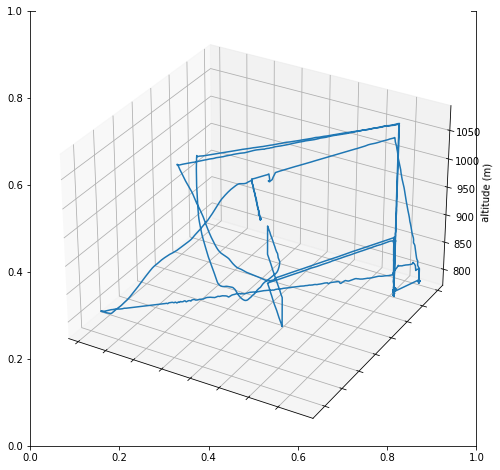

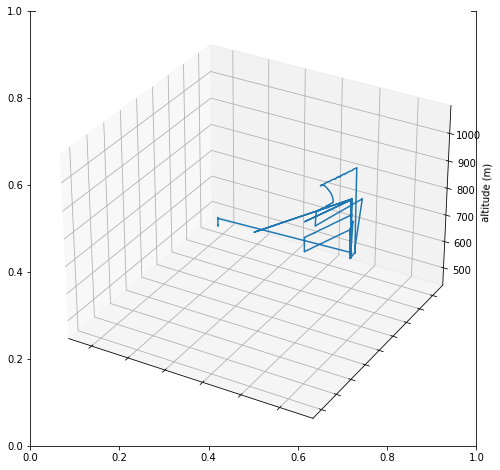

In [4]:
df3_data = read_data("la_palma_data/la palma 11-28-2021 - df3.log")
df4_data = read_data("la_palma_data/la palma 11-29-2021 - df4.log")

three_dimension(filter_data(df3_data, between('2021-11-27 12:55:31.676572', '2021-11-28 12:45:21.740369')))
three_dimension(filter_data(df4_data, between('2021-11-25 10:24:56.556887', '2021-11-29 11:11:25.253776')))

writecsv(filterReadings(df3_data), 'lapalma_df3_total.csv')
writecsv(filterReadings(df4_data), 'lapalma_df4_total.csv')

Flight 1

Takeoff location: 28.622203 -17.8737754
6742.9701538200015
m: 5445 count: 6742.9701538200015
mean 944.3447018124169 stdev: 82.20144376520301
Min Difference for 4557.951608204295: 40162.5989814631
Average: 944.3447018124169
Wrote lapalma_flight1.csv


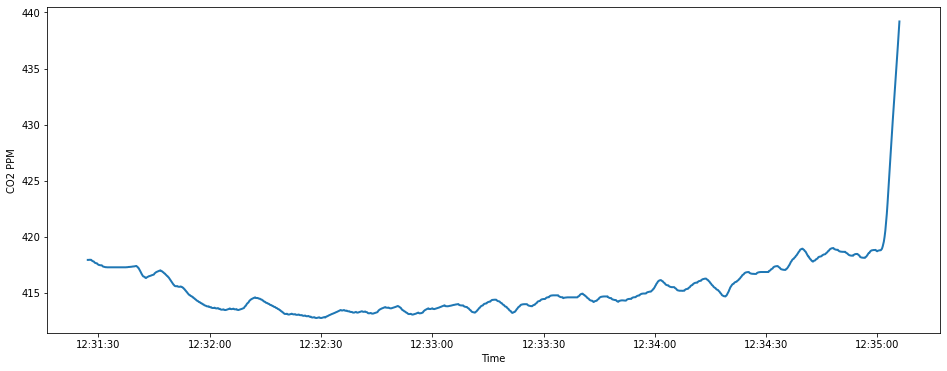

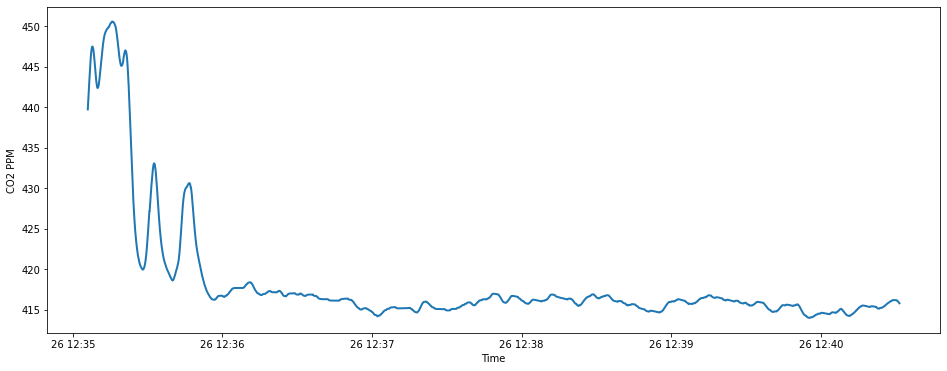

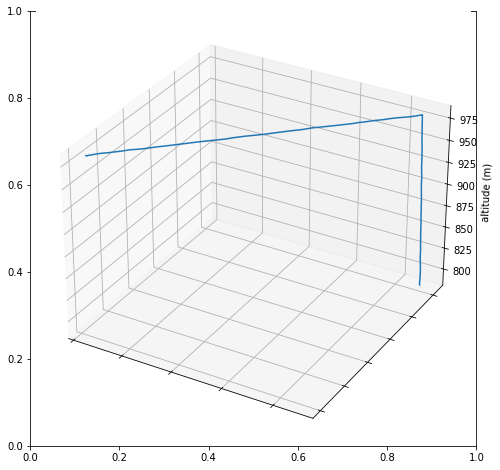

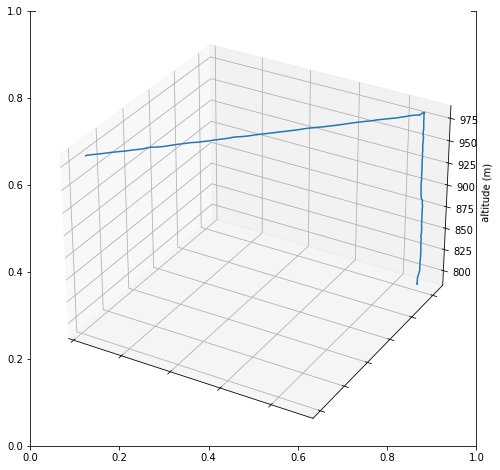

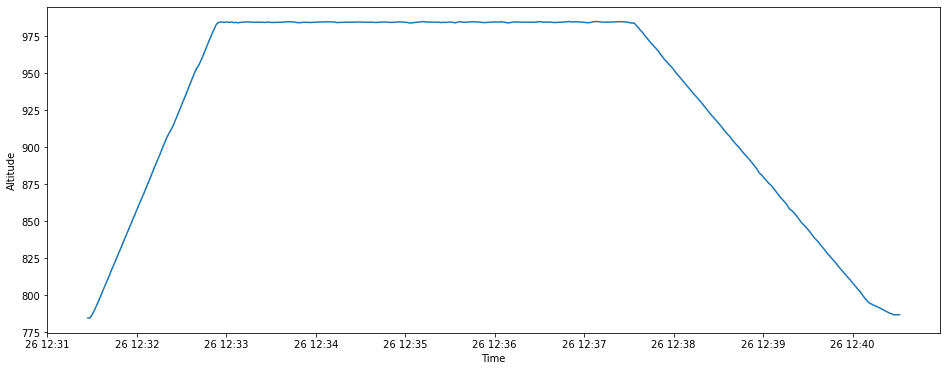

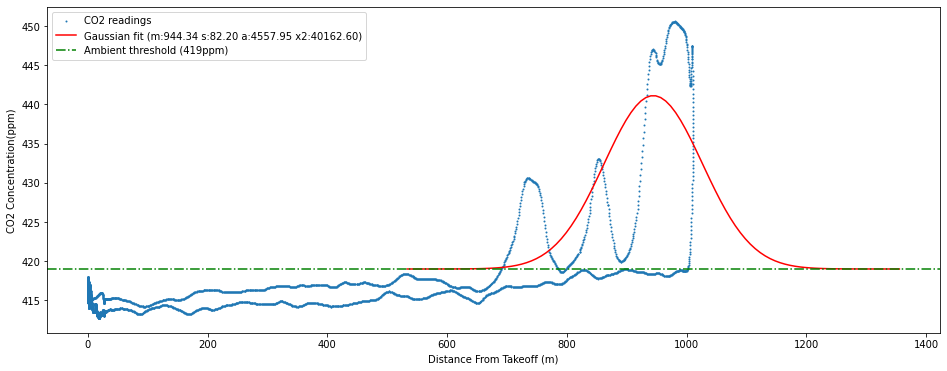

In [5]:
start1a = '2021-11-26 12:31:27.020316'  # Start at beginning waypoint
end1a = '2021-11-26 12:35:06.006446'    # Halfway through

start1b = '2021-11-26 12:35:06.006446'
end1b = '2021-11-26 12:40:31.575184'    # Landed



transect_1km_a = filter_data(df4_data, between(start1a, end1a))
transect_1km_b = filter_data(df4_data, between(start1b, end1b))

# df3_large_lawnmower = linearize(filter_data(df3_data, between(start, end)))

display_datas([transect_1km_a], colors=['C0'])
display_datas([transect_1km_b], colors=['C0'])

three_dimension(transect_1km_a)
three_dimension(transect_1km_b)

lapalma_flight1 = transect_1km_a + transect_1km_b
    

def display_distance_data(starting_position, data, ambient):
    print("Takeoff location: {} {}".format(starting_position.lat, starting_position.lon))
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    render_distance_data(starting_position, data, ambient, ax)

def render_distance_data(starting_position, data, ambient, ax, legend=True):
    total = 0
    count = 0
    
    distance_data = []
    distance_co2 = []
    earthCircumference = 40008000
    for d in data:
        lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
        lon_diff = (starting_position.lon - d.lon) * (earthCircumference / 360)
        distance = math.sqrt((lat_diff*lat_diff) + (lon_diff*lon_diff))
        distance_data.append(distance)
        distance_co2.append(d.value)
            
    for i in range(len(distance_data)):
        if distance_co2[i] > ambient:
            relative_co2 = distance_co2[i] - ambient
            total = total + (relative_co2 * distance_data[i])
            count = count + relative_co2
            
    print(count)
        
    mean = total / count
    
    std_total = 0
    for i in range(len(distance_data)):
        if distance_co2[i] > ambient:
            relative_co2 = distance_co2[i] - ambient
            distance_diff = distance_data[i] - mean
            std_total = std_total + (relative_co2 * (distance_diff * distance_diff))
        
    m = len(distance_co2)
    print("m: {} count: {}".format(m, count))
    std_dev = math.sqrt(std_total / (((m-1) / m) * count))
        
    print("mean {} stdev: {}".format(mean, std_dev))
    
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(((-(((x - mean) / stddev) ** 2)) / 2)) / (stddev * math.sqrt(2 * math.pi))


    def difference(s):
        difference_sum = 0
        for i in range(len(distance_co2)) :
            if distance_co2[i] > ambient:
                calculated_value = gaussian(distance_data[i], s, mean, std_dev)
                calculated_difference = distance_co2[i] - ambient
                difference = calculated_value - calculated_difference
                difference_sum = difference_sum + (difference ** 2)
        return difference_sum
    
    def gradient_descent(current, step_size, max_iter):
        current_x = current
        prev_difference = 1
        rate = 1
        precision = 0.00001
        previous_step_size = step_size
        
        for i in range(max_iter):
            previous_x = current_x
            
            value = difference(previous_x)
            value_plus = difference(previous_x + (previous_step_size * 0.1))
            
            df = (value_plus - value) / (step_size * 0.1)
            
            current_x = current_x - (rate * df)
            
#             print("Iteration",i,"\nX value is",current_x)
            
        
#         print("The local minimum occurs at", current_x)
        return [current_x, difference(current_x)]
            
    
    [minimum_s, minimum_x2] = gradient_descent(0, 100, 1000)

    print ("Min Difference for {}: {}".format(minimum_s, minimum_x2))   
    
    print("Average: {}".format((total / count)) )
        
    x = np.linspace(mean - 5*std_dev, mean + 5*std_dev, 100)
    pdf = [(x) + ambient for x in gaussian(x, minimum_s, mean, std_dev)]
    
    ax.scatter(distance_data, distance_co2, s=1, label="CO2 readings")
    ax.plot(x, pdf, c='r', label='Gaussian fit (m:{:.2f} s:{:.2f} a:{:.2f} x2:{:.2f})'.format(mean, std_dev, minimum_s, minimum_x2))
    ax.axhline(y = ambient, color = 'g', linestyle = '-.', label="Ambient threshold ({}ppm)".format(ambient))
    ax.set_xlabel('Distance From Takeoff (m)')
    ax.set_ylabel('CO2 Concentration(ppm)')
    if legend:
        ax.legend()
    ax.plot()
    

display_data_altitude(lapalma_flight1)
display_distance_data(lapalma_flight1[0], lapalma_flight1, 419)

writecsv(lapalma_flight1, 'lapalma_flight1.csv')



Takeoff location: 28.6222283 -17.8737869
16815.970245350993
m: 3289 count: 16815.970245350993
mean 549.9108391842917 stdev: 60.97713925904756
Min Difference for 13398.64135700196: 18961.956125844976
Average: 549.9108391842917
Takeoff location: 28.6222282 -17.8737884
4064.1896362240004
m: 3000 count: 4064.1896362240004
mean 236.88201245180014 stdev: 147.75277578615993
Min Difference for 3657.6280168854096: 13592.329757087518
Average: 236.88201245180014
Takeoff location: 28.6222283 -17.8737869
20880.159881574975
m: 6289 count: 20880.159881574975
mean 488.99229900201846 stdev: 150.3356328311018
Min Difference for 15010.143873949117: 435493.9296896039
Average: 488.99229900201846
Wrote lapalma_flight2a.csv
Wrote lapalma_flight2.csv


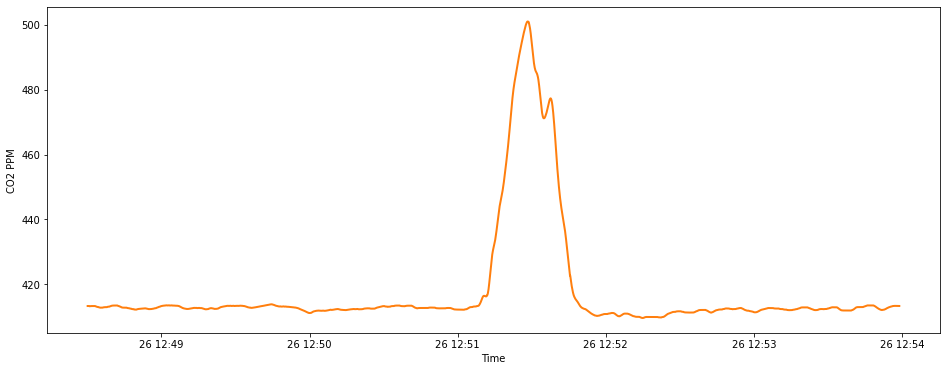

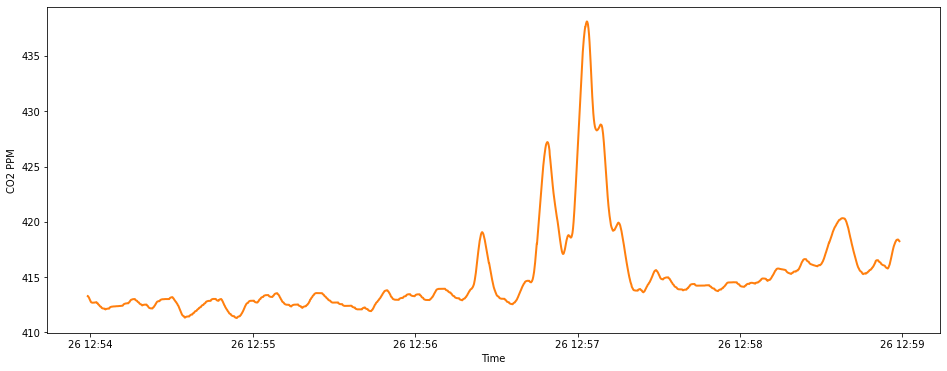

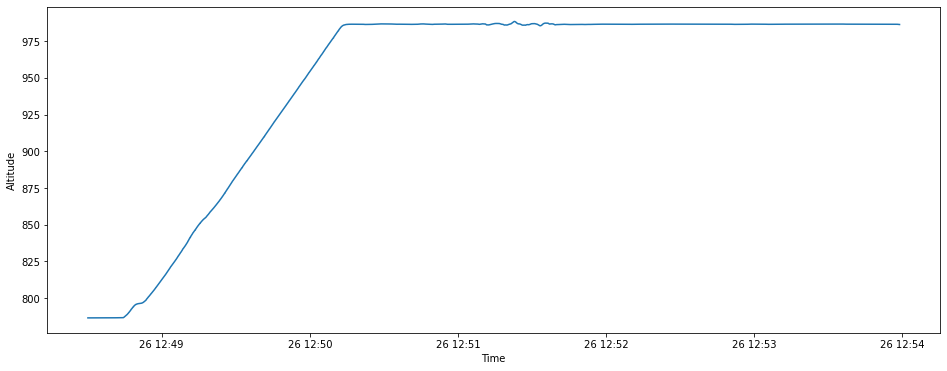

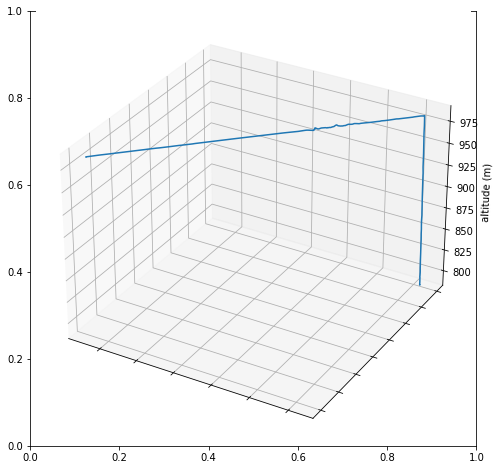

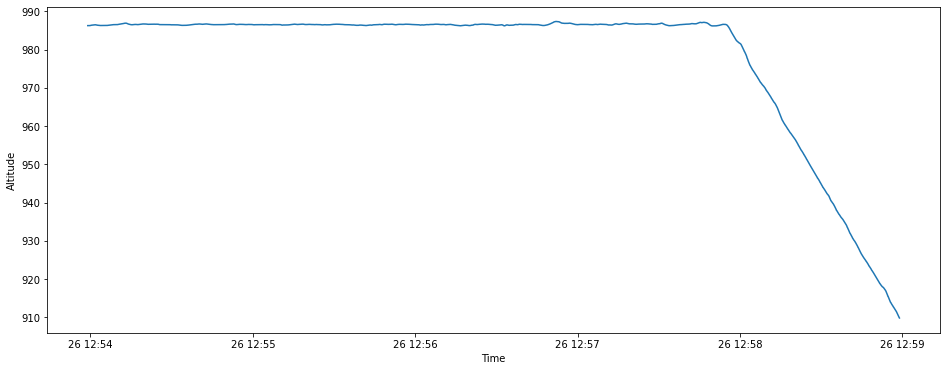

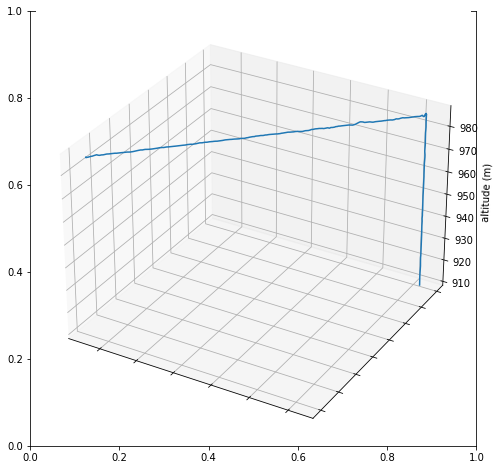

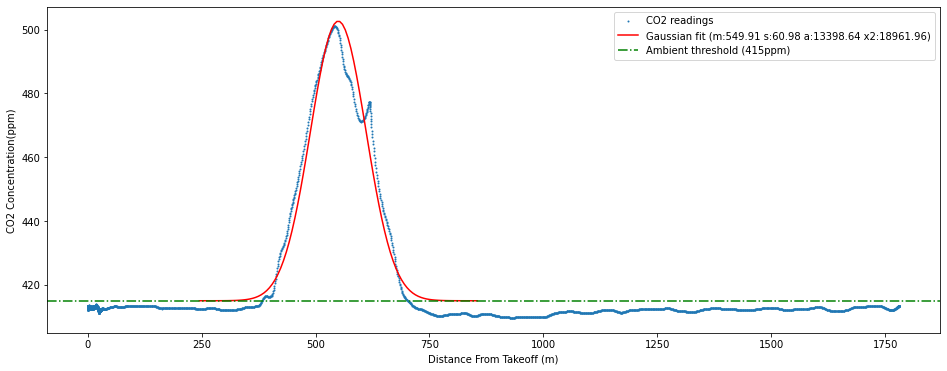

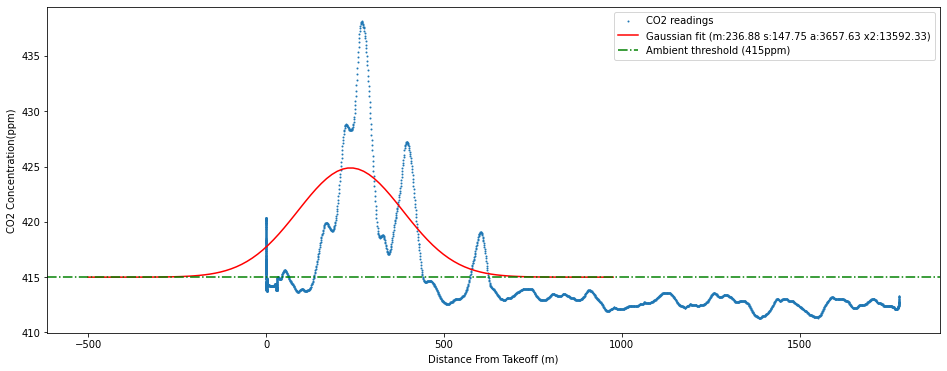

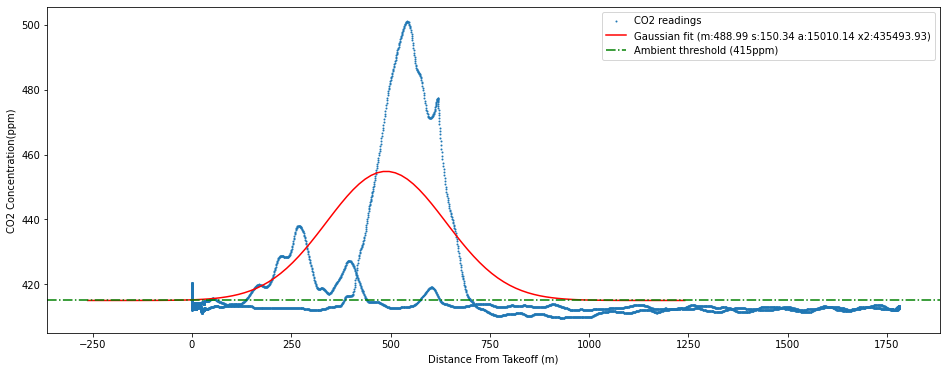

In [6]:
start2a = '2021-11-26 12:48:30.019876'  
end2a = '2021-11-26 12:53:59.006718'

start2b = '2021-11-26 12:53:59.006718'
end2b = '2021-11-26 12:58:59.005814'
lapalma_flight2a = filter_data(df4_data, between(start2a, end2a))
lapalma_flight2b = filter_data(df4_data, between(start2b, end2b))
display_datas([lapalma_flight2a], colors=['C1'])
plt.savefig("flight2_out_co2.pdf", format="pdf")
display_datas([lapalma_flight2b], colors=['C1'])
plt.savefig("flight2_in_co2.pdf", format="pdf")

display_data_altitude(lapalma_flight2a)
three_dimension(lapalma_flight2a)
plt.savefig("flight2.pdf", format="pdf")
display_data_altitude(lapalma_flight2b)
three_dimension(lapalma_flight2b)

display_distance_data(lapalma_flight2a[0], lapalma_flight2a, 415)
plt.savefig("laplama_flight2a.pdf", format="pdf")
display_distance_data(lapalma_flight2b[len(lapalma_flight2b) - 1], lapalma_flight2b, 415)
display_distance_data(lapalma_flight2a[0], (lapalma_flight2a + lapalma_flight2b), 415)

writecsv(lapalma_flight2a, 'lapalma_flight2a.csv')
writecsv((lapalma_flight2a + lapalma_flight2b), 'lapalma_flight2.csv')

In [7]:
# from mpl_toolkits.basemap import Basemap

def display_scatter_on_map(readings, draw_path=False):
    fig, ax = plt.subplots(figsize=(16, 6))
    
    lat_1 = min([r.lat for r in readings])
    lat_2 = max([r.lat for r in readings])
    lon_1 = min([r.lon for r in readings])
    lon_2 = max([r.lon for r in readings])
    
#     m = Basemap(width=12000000,height=9000000,projection='lcc',
#             resolution=None, lat_0=lat_1, lat_2=lat_2, lon_0=lon_1)

#     m.bluemarble()
    
    plot_scatter(fig, ax, readings, draw_path)

    zoom_to_data(ax, readings)
    geo_axis_format(ax)

    ax.plot()


# display_scatter_on_map(transect_1km_a)
# display_scatter_on_map(transect_1km_b)
# display_scatter_on_map(transect_2km_a)
# display_scatter_on_map(transect_2km_b)


Takeoff location: 28.6222099 -17.8737807
3505.959289574986
m: 5530 count: 3505.959289574986
mean 73.59562856293465 stdev: 226.10704468977127
Min Difference for 834.1596818875909: 946.5898154513487
Average: 73.59562856293465
Wrote lapalma_flight3.csv


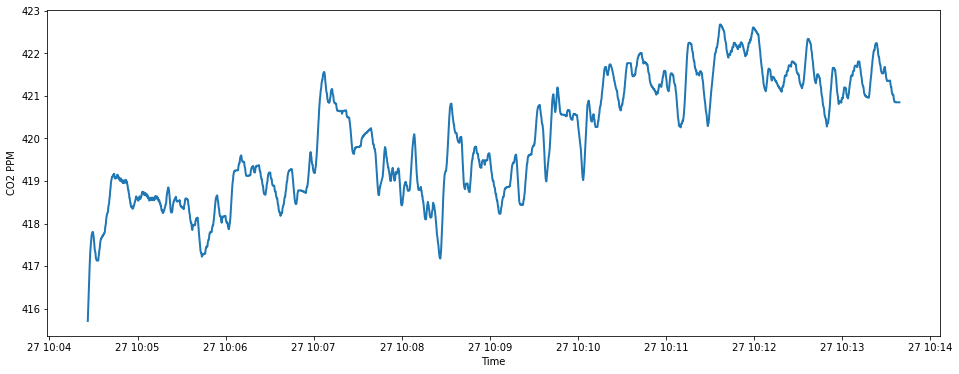

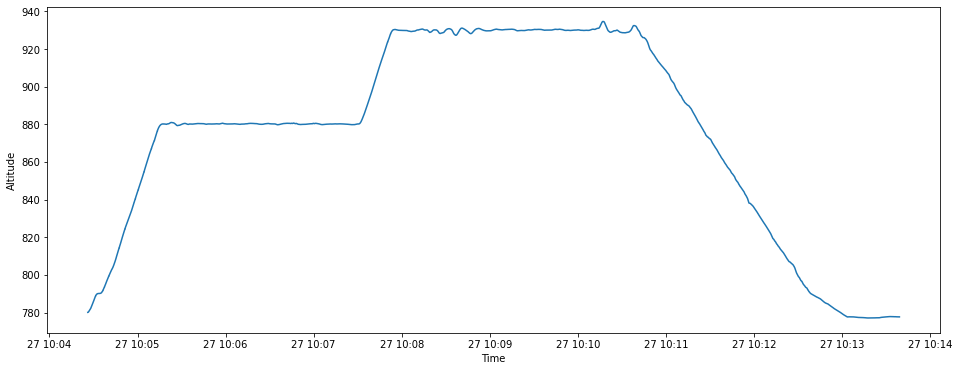

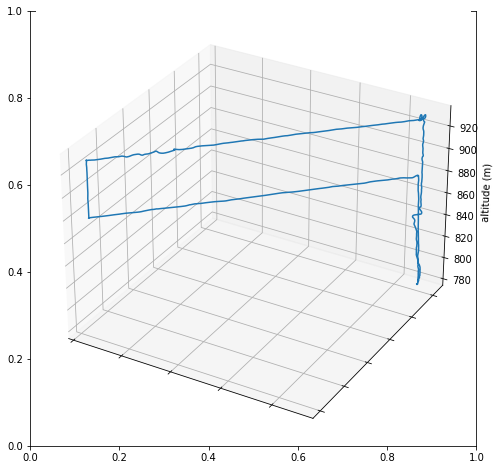

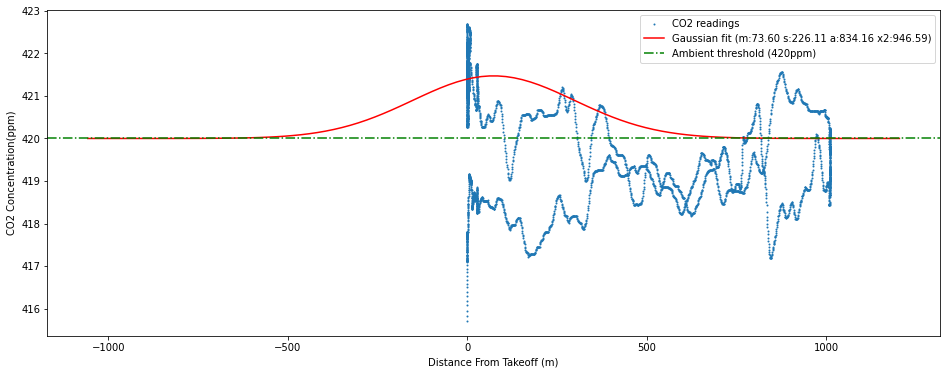

In [8]:

starttest = '2021-11-27 10:04:25.135506'
endtest = '2021-11-27 10:13:39.120506'

lapalma_flight3 = filter_data(df4_data, between(starttest, endtest))
display_datas([lapalma_flight3], colors=['C0'])

display_data_altitude(lapalma_flight3)
three_dimension(lapalma_flight3)
display_distance_data(lapalma_flight3[0], lapalma_flight3, 420)
writecsv(lapalma_flight3, 'lapalma_flight3.csv')

Takeoff location: 28.6221729 -17.8737895
18803.129608158997
m: 6884 count: 18803.129608158997
mean 1063.6060120081706 stdev: 113.3342335306933
Min Difference for 6265.498422984784: 58691.82143146228
Average: 1063.6060120081706
Wrote lapalma_flight4.csv


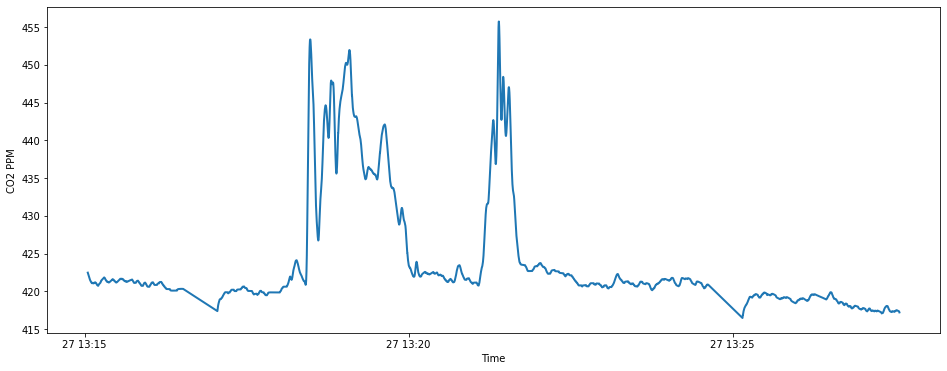

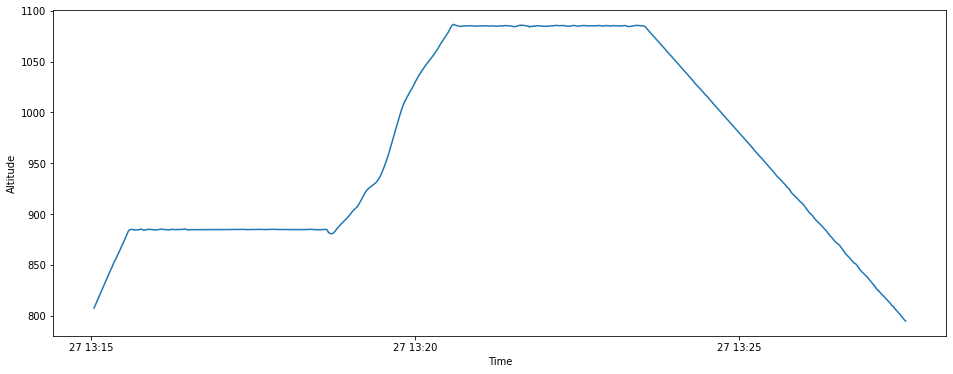

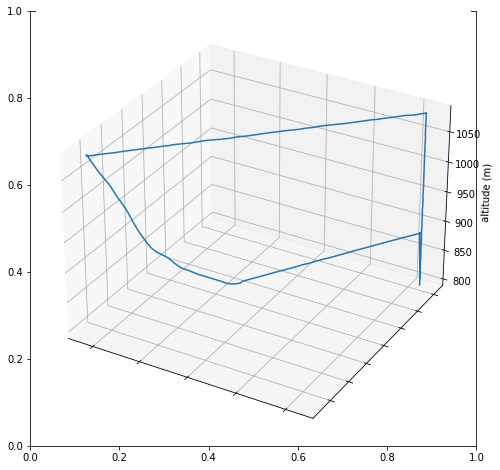

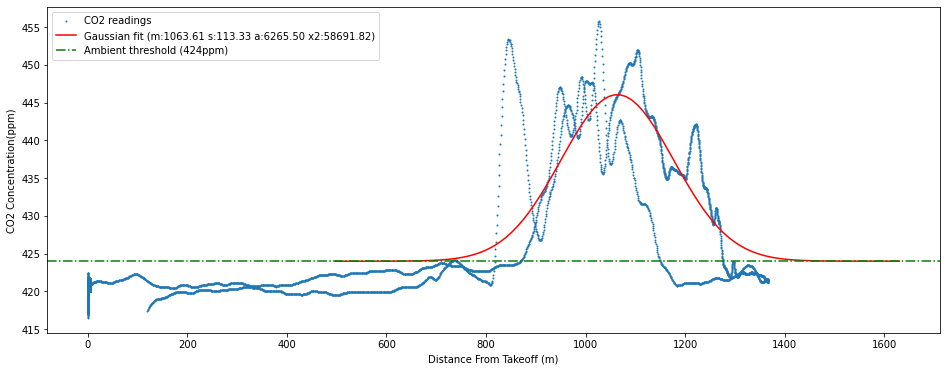

In [9]:

starttest = '2021-11-27 13:15:02.982099'
endtest = '2021-11-27 13:27:34.548221'

lapalma_flight4 = filter_data(df3_data, between(starttest, endtest))
display_datas([lapalma_flight4], colors=['C0'])

display_data_altitude(lapalma_flight4)
three_dimension(lapalma_flight4)

display_distance_data(lapalma_flight4[0], lapalma_flight4, 424)
writecsv(lapalma_flight4, 'lapalma_flight4.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Takeoff location: 28.6222246 -17.8738154
152976.89904786157
m: 11322 count: 152976.89904786157
mean 1015.9807653379999 stdev: 349.0541241760263
Min Difference for 42086.46646754258: 8584467.475884184
Average: 1015.9807653379999
Takeoff location: 28.6222246 -17.8738154
49637.38000488998
m: 1200 count: 49637.38000488998
mean 612.6921750782703 stdev: 111.21626241937268


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Min Difference for 40873.99789336113: 426304.9318525154
Average: 612.6921750782703
Takeoff location: 28.6222246 -17.8738154
32279.089416509003
m: 2700 count: 32279.089416509003
mean 1332.077852277563 stdev: 74.52555972619344
Min Difference for 9933.164993833963: 1693498.1387949968
Average: 1332.077852277563
Takeoff location: 28.6222246 -17.8738154
20678.039978015986
m: 1200 count: 20678.039978015986
mean 741.1049841074388 stdev: 67.40158179706538
Min Difference for 17109.548599995895: 277696.0825131589
Average: 741.1049841074388
Wrote lapalma_flight5.csv


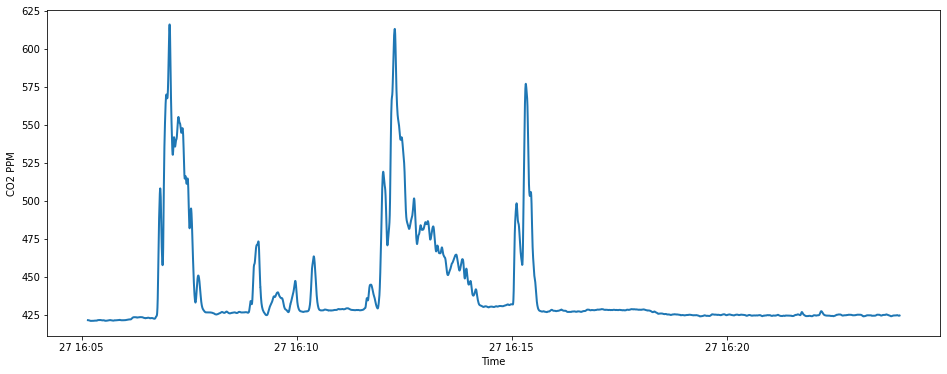

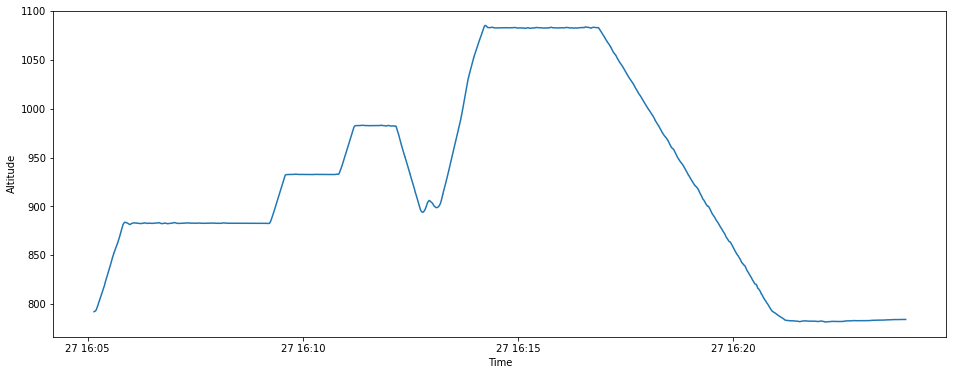

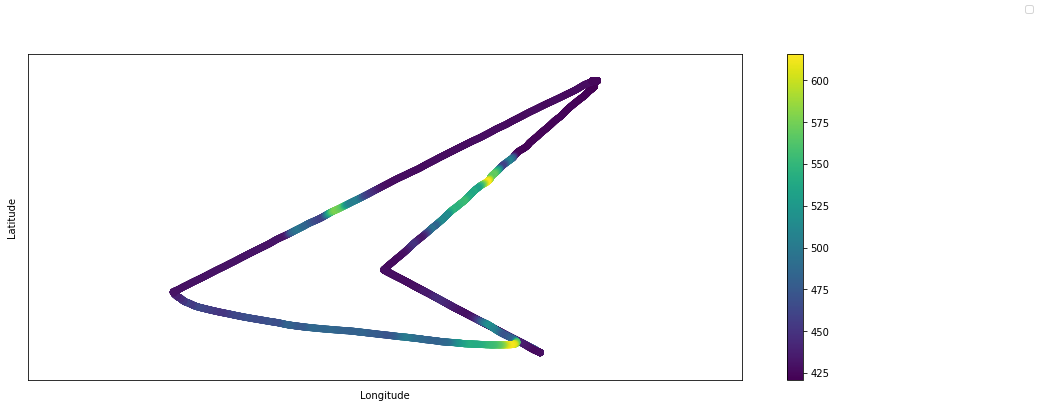

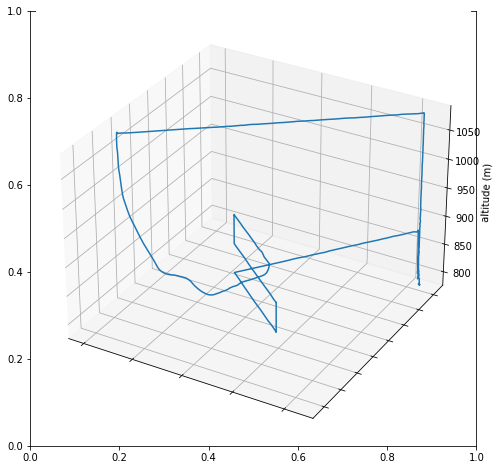

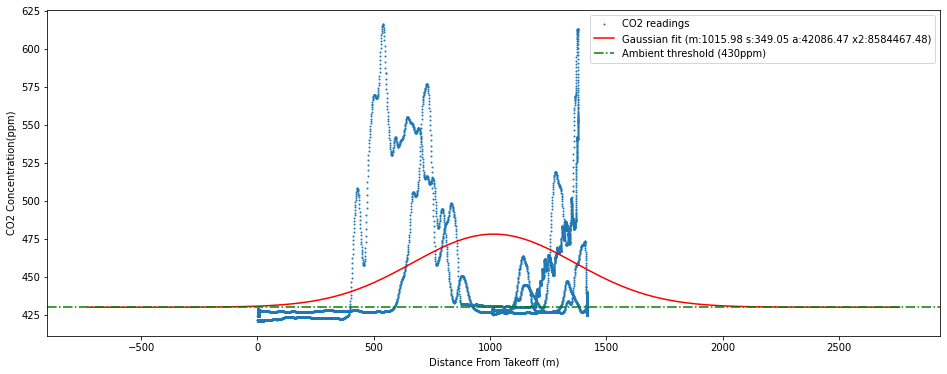

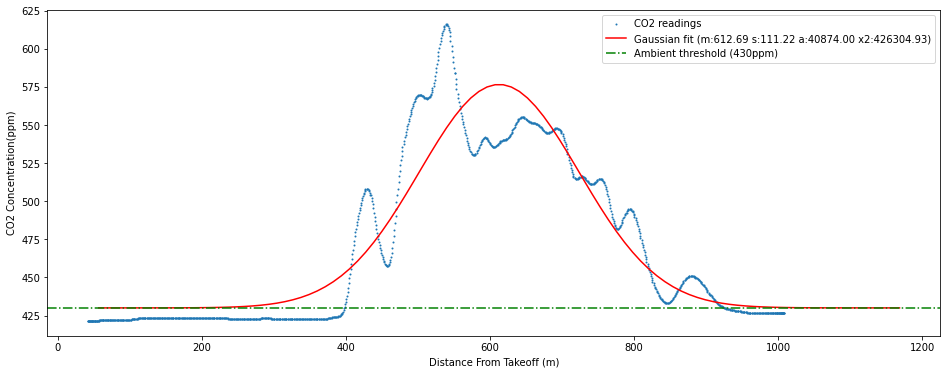

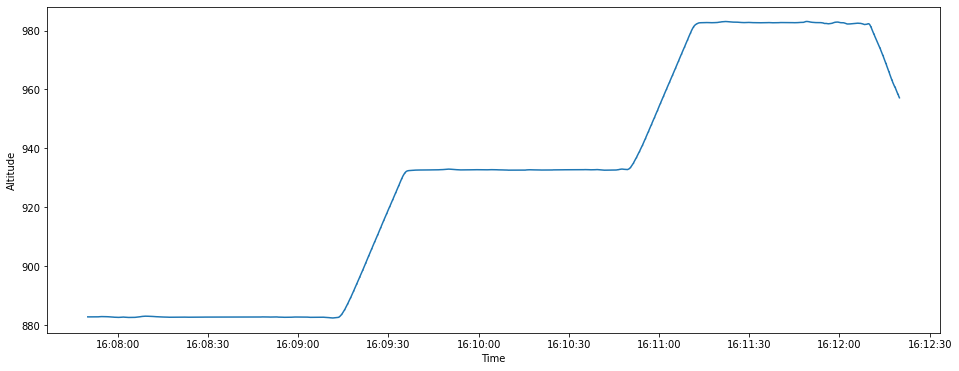

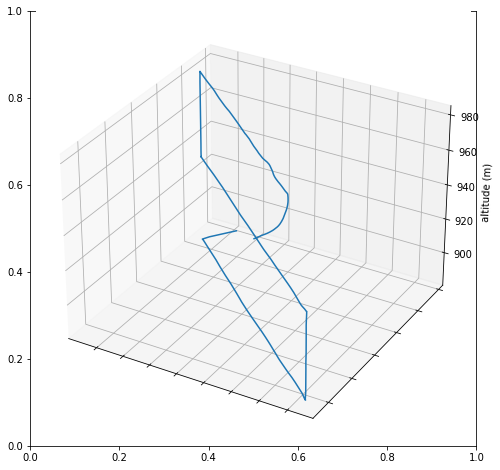

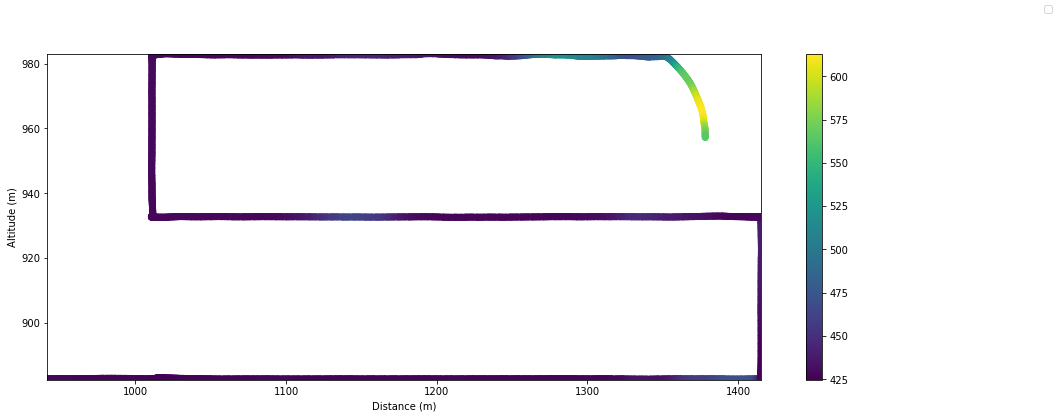

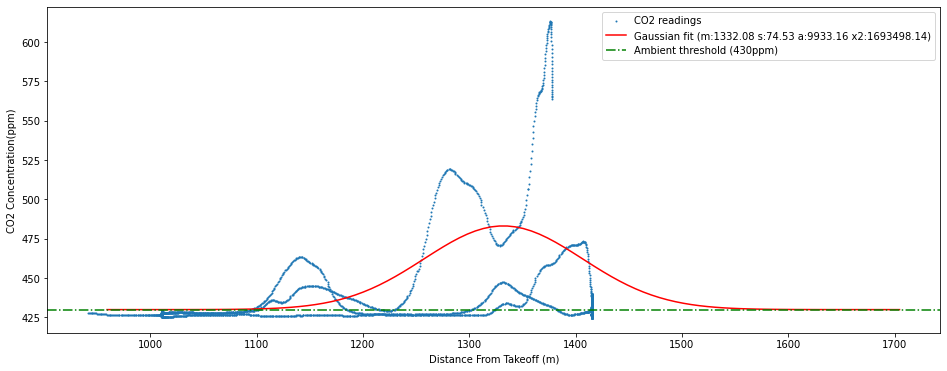

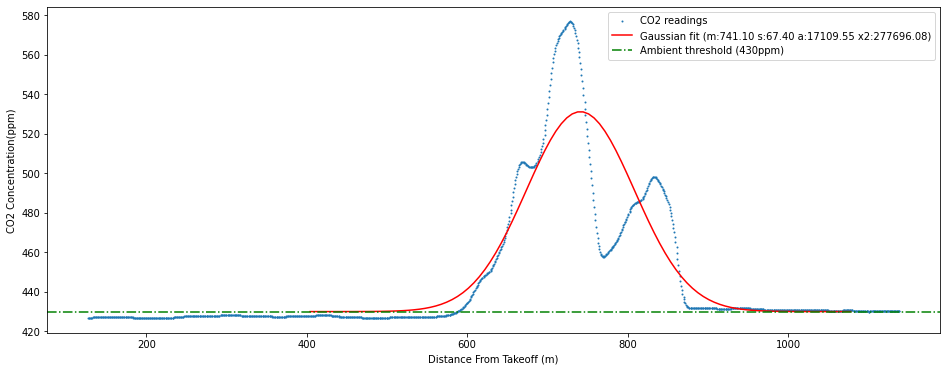

In [10]:
starttest = '2021-11-27 16:05:08.784123'
endtest = '2021-11-27 16:24:0.942152'

def three_dimension_scatter(starting_position, readings):
    fig, ax = plt.subplots(figsize=(16, 6))
    
    values = [1.0 * r.value for r in readings]
    
    distance_data = []
    distance_co2 = []
    earthCircumference = 40008000
    for d in readings:
        lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
        lon_diff = (starting_position.lon - d.lon) * (earthCircumference / 360)
        distance = math.sqrt((lat_diff*lat_diff) + (lon_diff*lon_diff))
        distance_data.append(distance)
        distance_co2.append(d.value)
    
    sc = ax.scatter(distance_data,
                    [r.alt for r in readings],
                    c=values,
                    marker='o')


    ax.set_xlabel('Distance (m)')
    ax.set_xlim(min(distance_data), max(distance_data))


    ax.set_ylabel('Altitude (m)')
    ax.set_ylim(min([r.alt for r in readings]), max([r.alt for r in readings]))

    fig.colorbar(sc)

    fig.legend()

#     zoom_to_data(ax, readings)
#     geo_axis_format(ax)

    ax.plot()

lapalma_flight5 = filter_data(df3_data, between(starttest, endtest))
display_datas([lapalma_flight5], colors=['C0'])
plt.savefig("flight5_co2.pdf", format="pdf")

display_data_altitude(lapalma_flight5)

display_scatter_on_map(lapalma_flight5)

three_dimension(lapalma_flight5)
plt.savefig("flight5.pdf", format="pdf")

display_distance_data(lapalma_flight5[0], lapalma_flight5, 430)

first_plume = filter_data(df3_data, between('2021-11-27 16:06:00.0', '2021-11-27 16:08:00.0'))
display_distance_data(lapalma_flight5[0], first_plume, 430)

curtain_plume = filter_data(df3_data, between('2021-11-27 16:07:50.0', '2021-11-27 16:12:20.0'))
display_data_altitude(curtain_plume)
three_dimension(curtain_plume)
three_dimension_scatter(lapalma_flight5[0], curtain_plume)
display_distance_data(lapalma_flight5[0], curtain_plume, 430)

returning_plume = filter_data(df3_data, between('2021-11-27 16:14:30.0', '2021-11-27 16:16:30.0'))
display_distance_data(lapalma_flight5[0], returning_plume, 430)

writecsv(lapalma_flight5, 'lapalma_flight5.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Takeoff location: 28.6245587 -17.8734175
161537.90066528195
m: 9364 count: 161537.90066528195
mean 1641.3912035418123 stdev: 201.9104030033157
Min Difference for 64944.73432652028: 21987527.2194353
Average: 1641.3912035418123
Wrote lapalma_flight6.csv


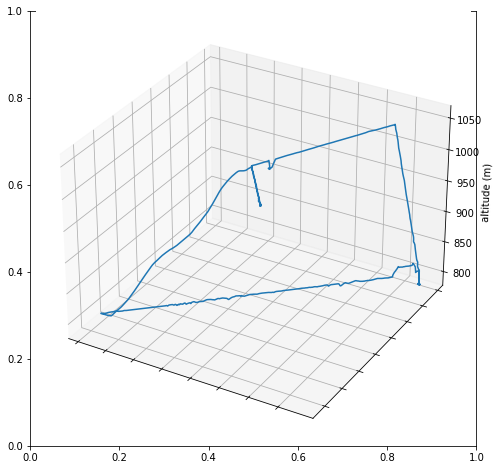

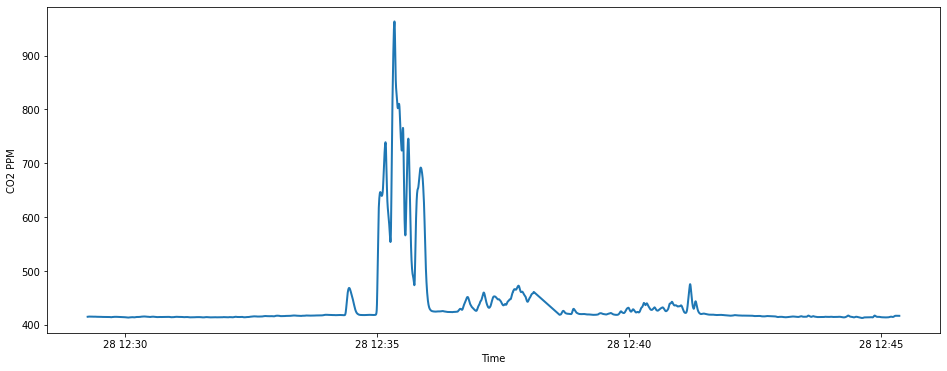

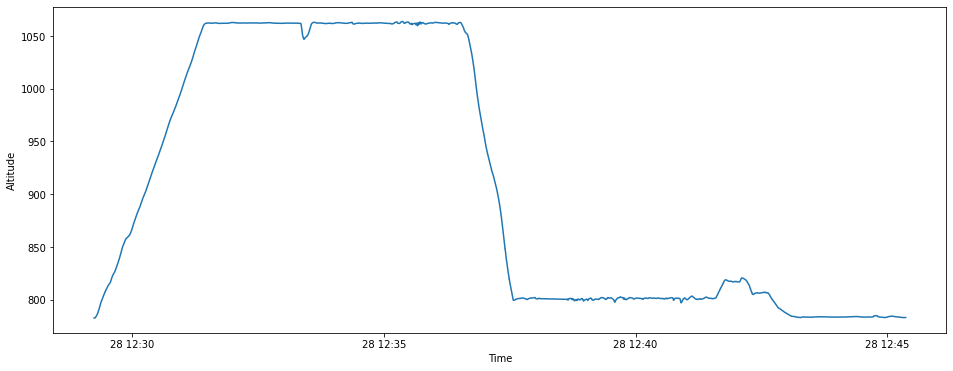

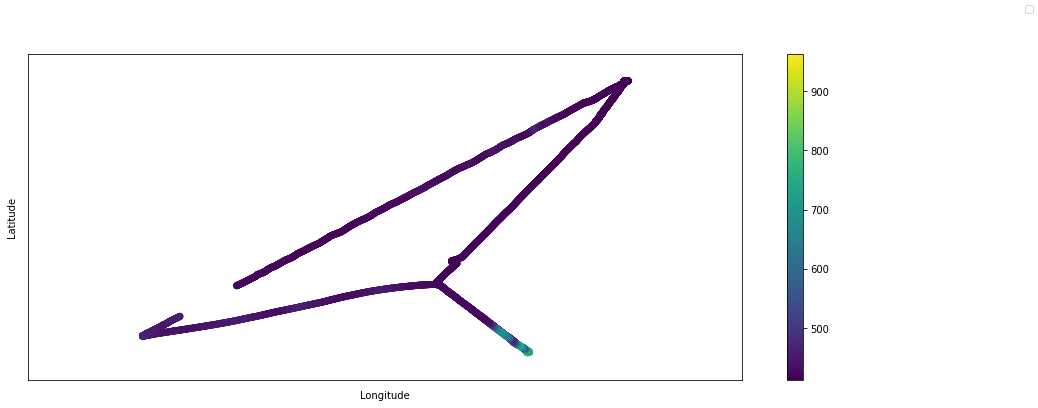

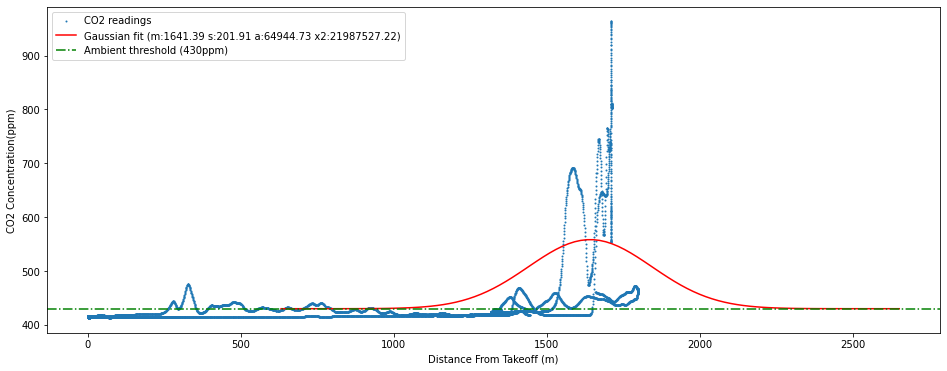

In [11]:
starttest = '2021-11-28 12:29:14.86601'
endtest = '2021-11-28 12:45:21.740369'

lapalma_flight6 = filter_data(df3_data, between(starttest, endtest))
three_dimension(lapalma_flight6)
display_datas([lapalma_flight6], colors=['C0'])

display_data_altitude(lapalma_flight6)
display_scatter_on_map(lapalma_flight6)

display_distance_data(lapalma_flight6[0], lapalma_flight6, 430)
writecsv(lapalma_flight6, 'lapalma_flight6.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Takeoff location: 28.6232604 -17.872857
12123.129608164014
m: 4308 count: 12123.129608164014
mean 1111.8747545588851 stdev: 35.005199393191205
Min Difference for 2167.4754164964443: 145685.15738574896
Average: 1111.8747545588851
Wrote lapalma_flight8.csv


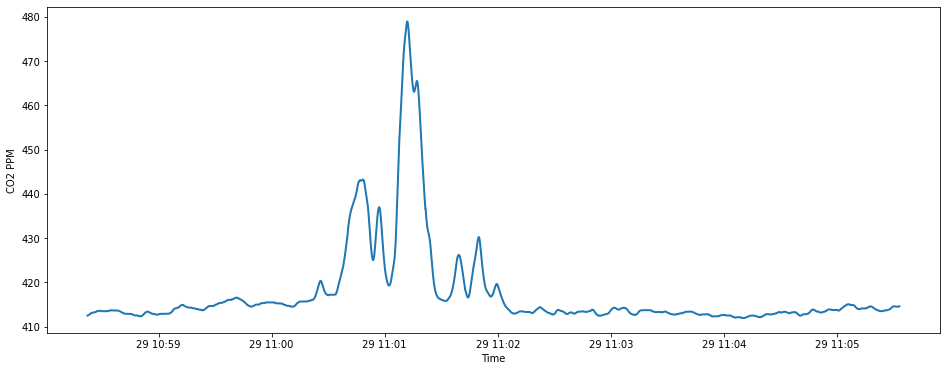

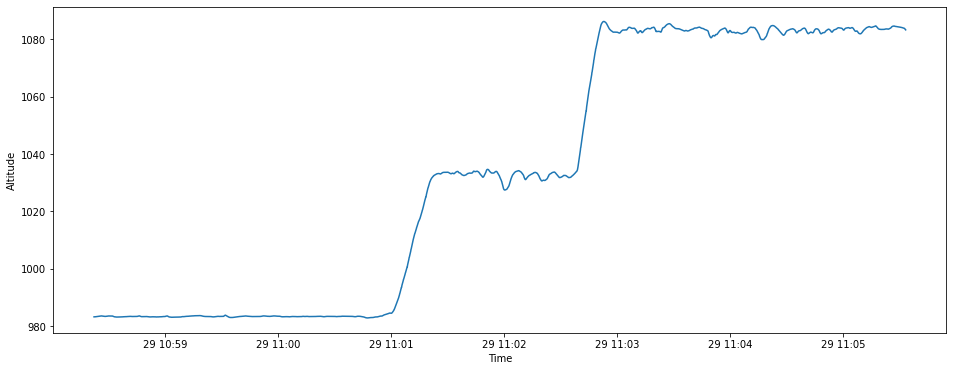

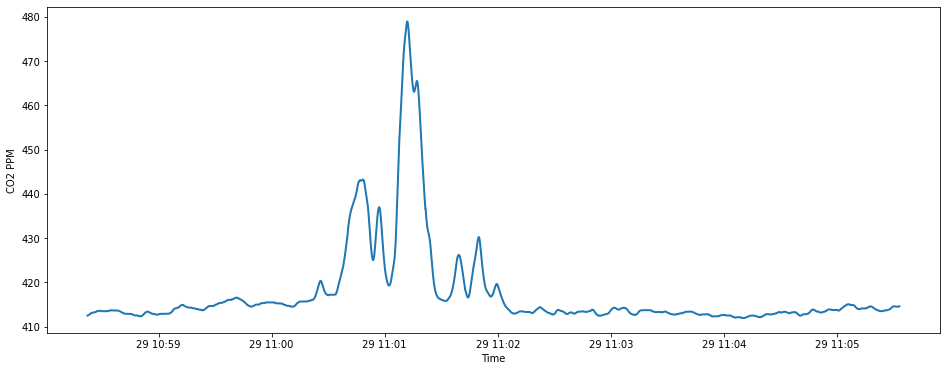

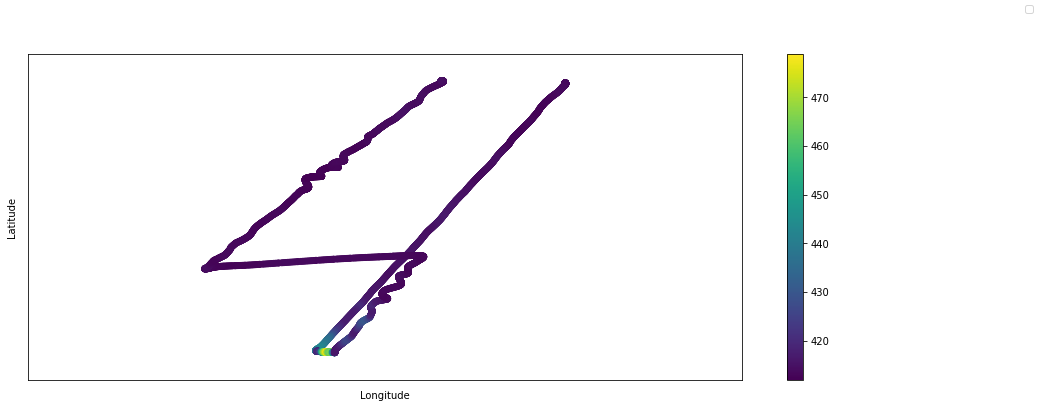

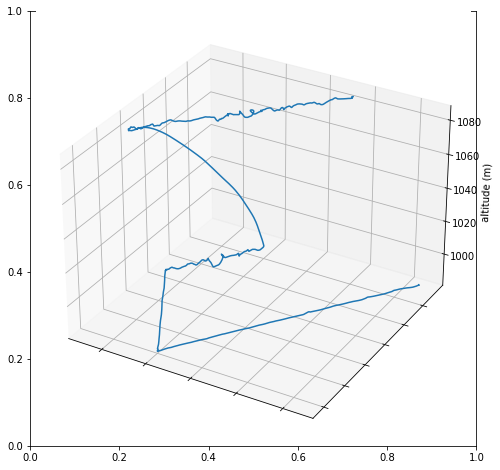

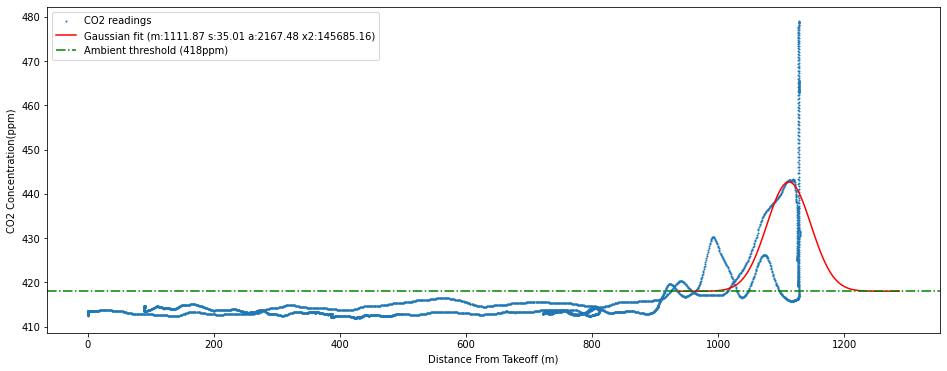

In [12]:
starttest = '2021-11-29 10:58:22.295029'
endtest = '2021-11-29 11:05:33.152931'

lapalma_flight8 = filter_data(df4_data, between(starttest, endtest))
display_datas([lapalma_flight8], colors=['C0'])

display_data_altitude(lapalma_flight8)
display_datas([lapalma_flight8], colors=['C0'])
display_scatter_on_map(lapalma_flight8)

three_dimension(lapalma_flight8)
display_distance_data(lapalma_flight8[0], lapalma_flight8, 418)
writecsv(lapalma_flight8, 'lapalma_flight8.csv')

6742.9701538200015
m: 5445 count: 6742.9701538200015
mean 944.3447018124169 stdev: 82.20144376520301
Min Difference for 4557.951608204295: 40162.5989814631
Average: 944.3447018124169
16815.970245350993
m: 3289 count: 16815.970245350993
mean 549.9108391842917 stdev: 60.97713925904756
Min Difference for 13398.64135700196: 18961.956125844976
Average: 549.9108391842917
4064.1896362240004
m: 3000 count: 4064.1896362240004
mean 236.88201245180014 stdev: 147.75277578615993
Min Difference for 3657.6280168854096: 13592.329757087518
Average: 236.88201245180014
20880.159881574975
m: 6289 count: 20880.159881574975
mean 488.99229900201846 stdev: 150.3356328311018
Min Difference for 15010.143873949117: 435493.9296896039
Average: 488.99229900201846
3505.959289574986
m: 5530 count: 3505.959289574986
mean 73.59562856293465 stdev: 226.10704468977127
Min Difference for 834.1596818875909: 946.5898154513487
Average: 73.59562856293465
18803.129608158997
m: 6884 count: 18803.129608158997
mean 1063.6060120081

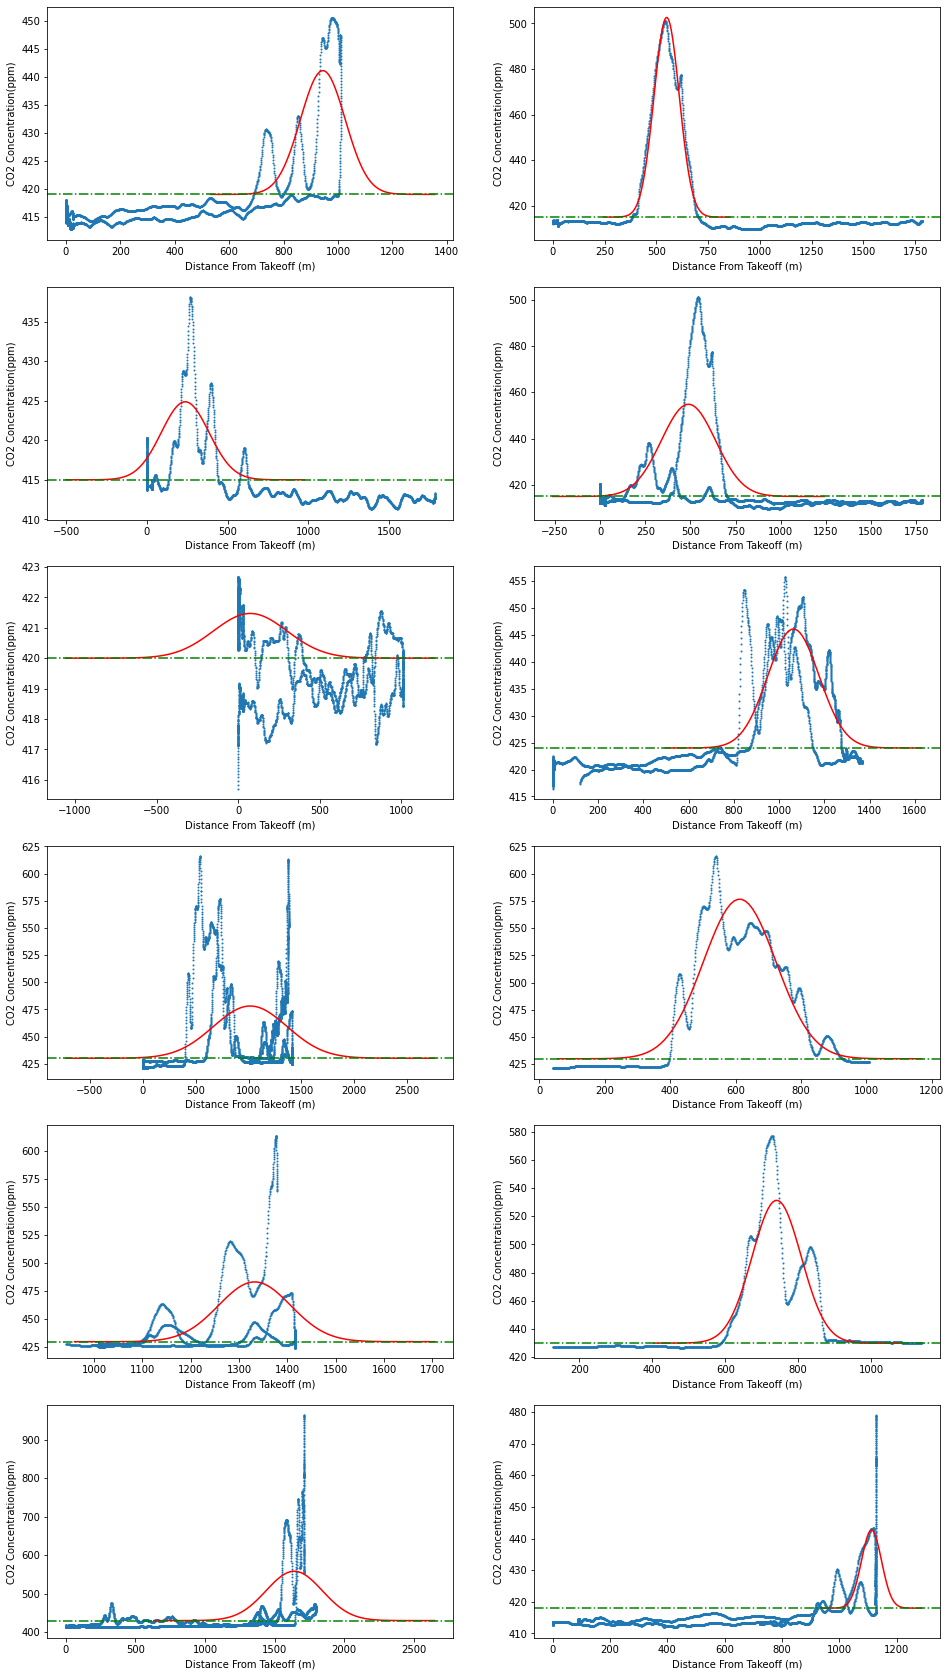

In [13]:
fig, axs = plt.subplots(6, 2, figsize=(16, 30))
render_distance_data(lapalma_flight1[0], lapalma_flight1, 419, axs[0,0], legend=False)

render_distance_data(lapalma_flight2a[0], lapalma_flight2a, 415, axs[0,1], legend=False)
render_distance_data(lapalma_flight2b[len(lapalma_flight2b) - 1], lapalma_flight2b, 415, axs[1,0], legend=False)
render_distance_data(lapalma_flight2a[0], (lapalma_flight2a + lapalma_flight2b), 415, axs[1,1], legend=False)

render_distance_data(lapalma_flight3[0], lapalma_flight3, 420, axs[2,0], legend=False)

render_distance_data(lapalma_flight4[0], lapalma_flight4, 424, axs[2,1], legend=False)


render_distance_data(lapalma_flight5[0], lapalma_flight5, 430, axs[3,0], legend=False)


render_distance_data(lapalma_flight5[0], first_plume, 430, axs[3,1], legend=False)
render_distance_data(lapalma_flight5[0], curtain_plume, 430, axs[4,0], legend=False)
render_distance_data(lapalma_flight5[0], returning_plume, 430, axs[4,1], legend=False)

render_distance_data(lapalma_flight6[0], lapalma_flight6, 430, axs[5,0], legend=False)

render_distance_data(lapalma_flight8[0], lapalma_flight8, 418, axs[5,1], legend=False)

plt.savefig("transects.pdf", format="pdf")

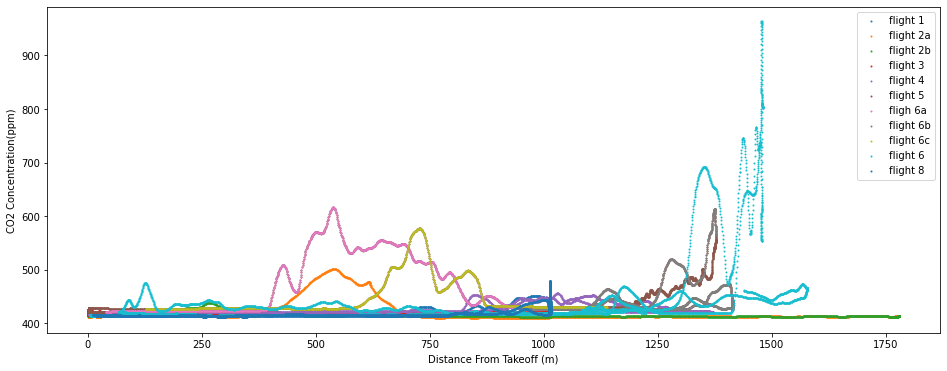

In [14]:
def display_distance_datas(starting_position, datas, names, legend=True):
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    earthCircumference = 40008000
    for i in range(len(datas)):
        data = datas[i]
        distance_data = []
        distance_co2 = []
        for d in data:
            lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
            lon_diff = (starting_position.lon - d.lon) * (earthCircumference / 360)
            distance = math.sqrt((lat_diff*lat_diff) + (lon_diff*lon_diff))
            distance_data.append(distance)
            distance_co2.append(d.value)
    
        ax.scatter(distance_data, distance_co2, s=1, label=names[i])
#     ax.plot(x, pdf, c='r', label='Gaussian fit (m:{:.2f} s:{:.2f} a:{:.2f} x2:{:.2f})'.format(mean, std_dev, minimum_s, minimum_x2))
#     ax.axhline(y = ambient, color = 'g', linestyle = '-.', label="Ambient threshold ({}ppm)".format(ambient))
    ax.set_xlabel('Distance From Takeoff (m)')
    ax.set_ylabel('CO2 Concentration(ppm)')
    if legend:
        ax.legend()
    ax.plot()
    
flight_list = [lapalma_flight1, lapalma_flight2a, lapalma_flight2b, lapalma_flight3, lapalma_flight4, lapalma_flight5, first_plume, curtain_plume, returning_plume, lapalma_flight6, lapalma_flight8]
flight_labels = ['flight 1', 'flight 2a', 'flight 2b', 'flight 3', 'flight 4', 'flight 5', 'fligh 6a', 'flight 6b', 'flight 6c', 'flight 6', 'flight 8']
    

display_distance_datas(lapalma_flight1[0],
                       flight_list,
                       flight_labels)
plt.savefig("distance_data.pdf", format="pdf")

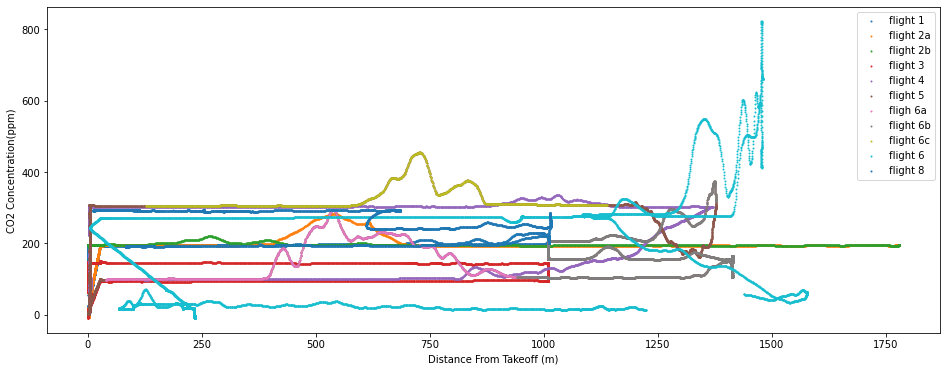

In [15]:
def display_distance_alt_datas(starting_position, datas, names, legend=True):
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    earthCircumference = 40008000
    for i in range(len(datas)):
        data = datas[i]
        distance_data = []
        distance_co2 = []
        for d in data:
            lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
            lon_diff = (starting_position.lon - d.lon) * (earthCircumference / 360)
            distance = math.sqrt((lat_diff*lat_diff) + (lon_diff*lon_diff))
            distance_data.append(distance)
            distance_co2.append(d.value - 420 + d.alt - starting_position.alt)
    
        ax.scatter(distance_data, distance_co2, s=1, label=names[i])
#     ax.plot(x, pdf, c='r', label='Gaussian fit (m:{:.2f} s:{:.2f} a:{:.2f} x2:{:.2f})'.format(mean, std_dev, minimum_s, minimum_x2))
#     ax.axhline(y = ambient, color = 'g', linestyle = '-.', label="Ambient threshold ({}ppm)".format(ambient))
    ax.set_xlabel('Distance From Takeoff (m)')
    ax.set_ylabel('CO2 Concentration(ppm)')
    if legend:
        ax.legend()
    ax.plot()

display_distance_alt_datas(lapalma_flight1[0], flight_list, flight_labels)
plt.savefig("distance_alt_datas.pdf", format="pdf")

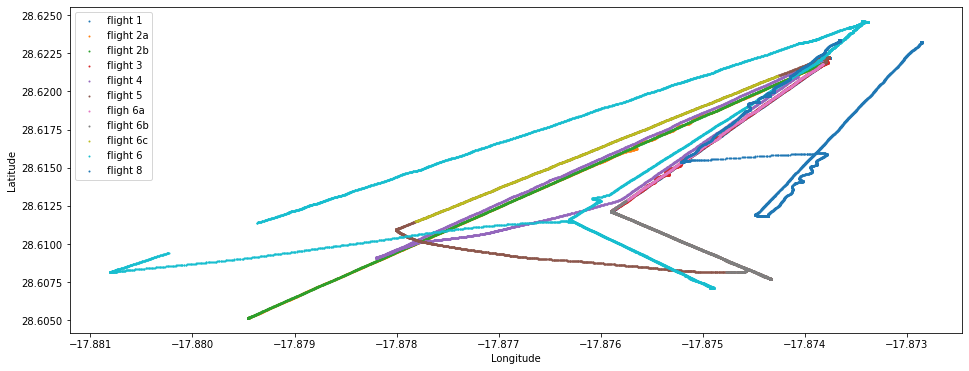

In [16]:
def display_lat_lon_datas(datas, names, legend=True):
    fig, ax = plt.subplots(figsize=(16, 6))
    
    earthCircumference = 40008000
    for i in range(len(datas)):
        data = datas[i]
        lat_data = []
        lon_data = []
        for d in data:
            lat_data.append(d.lat)
            lon_data.append(d.lon)
    
        ax.scatter(lon_data, lat_data, s=1, label=names[i])
#     ax.plot(x, pdf, c='r', label='Gaussian fit (m:{:.2f} s:{:.2f} a:{:.2f} x2:{:.2f})'.format(mean, std_dev, minimum_s, minimum_x2))
#     ax.axhline(y = ambient, color = 'g', linestyle = '-.', label="Ambient threshold ({}ppm)".format(ambient))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    if legend:
        ax.legend()
    ax.plot()
    
display_lat_lon_datas(flight_list, flight_labels)
plt.savefig("lat_lon_datas.pdf", format="pdf")

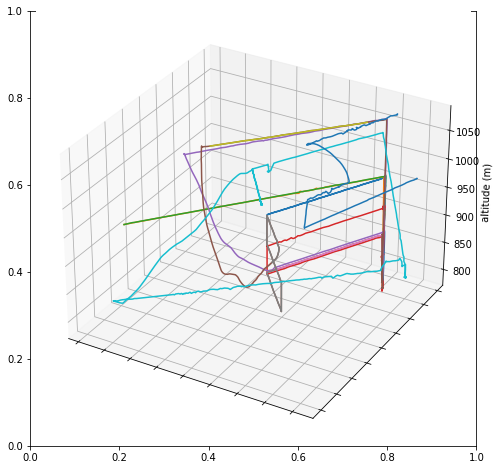

In [17]:
# flight_list = [lapalma_flight1, lapalma_flight2a, lapalma_flight2b, lapalma_flight3, lapalma_flight4, lapalma_flight5, first_plume, curtain_plume, returning_plume, lapalma_flight6, lapalma_flight8]
# flights = [item for sublist in flight_list for item in sublist]
three_dimensions(flight_list, flight_labels)
plt.savefig("three_dimensions.pdf", format="pdf")

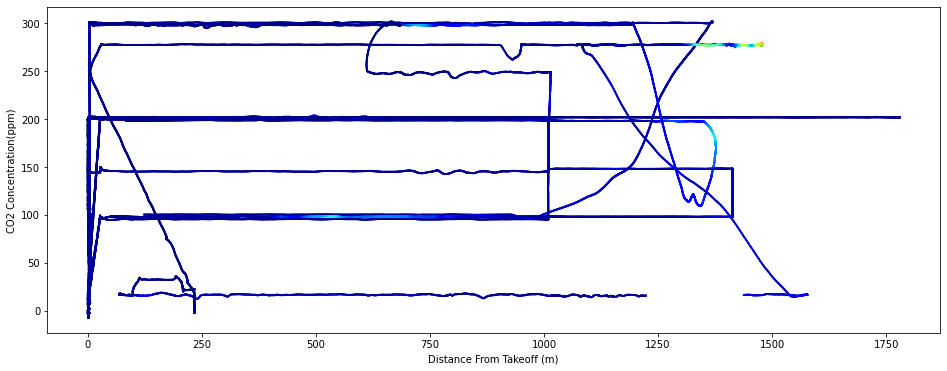

In [18]:
def display_distance_alt_datas(starting_position, datas, names, legend=True):
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    earthCircumference = 40008000
    distance_data = []
    distance_co2 = []
    co2 = []
    for i in range(len(datas)):
        data = datas[i]
        for d in data:
            lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
            lon_diff = (starting_position.lon - d.lon) * (earthCircumference / 360)
            distance = math.sqrt((lat_diff*lat_diff) + (lon_diff*lon_diff))
            distance_data.append(distance)
            distance_co2.append(d.alt - starting_position.alt)
            co2.append(d.value)
    
    ax.scatter(distance_data, distance_co2, s=1, c=co2, cmap='jet')
#     ax.plot(x, pdf, c='r', label='Gaussian fit (m:{:.2f} s:{:.2f} a:{:.2f} x2:{:.2f})'.format(mean, std_dev, minimum_s, minimum_x2))
#     ax.axhline(y = ambient, color = 'g', linestyle = '-.', label="Ambient threshold ({}ppm)".format(ambient))
    ax.set_xlabel('Distance From Takeoff (m)')
    ax.set_ylabel('CO2 Concentration(ppm)')
    if legend:
        ax.legend()
    ax.plot()
    
flight_list = [lapalma_flight1, lapalma_flight2a, lapalma_flight2b, lapalma_flight3, lapalma_flight4, lapalma_flight5, first_plume, curtain_plume, returning_plume, lapalma_flight6, lapalma_flight8]
flight_labels = ['flight 1', 'flight 2a', 'flight 2b', 'flight 3', 'flight 4', 'flight 5', 'fligh 6a', 'flight 6b', 'flight 6c', 'flight 6', 'flight 8']
    

display_distance_alt_datas(lapalma_flight1[0], flight_list, flight_labels, legend=False)
plt.savefig("distance_alt_data.pdf", format="pdf")

In [ ]:
def display_altitude_distance_krig(name, starting_position, readings, nlags=6, minco2=None, maxco2=None, addons=None):
    fig, ax = plt.subplots(figsize=(16, 6))
    
    earthCircumference = 40008000
    distance_data = []
    co2 = []
    altitude = []
    
    for i in range(len(readings)):
        d = readings[i]
        lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
        lon_diff = (starting_position.lon - d.lon) * (earthCircumference / 360)
        distance = math.sqrt((lat_diff*lat_diff) + (lon_diff*lon_diff))
        distance_data.append(distance)
        altitude.append(d.alt)
        co2.append(float(d.value))

    plot_krige(name, fig, ax, distance_data, altitude, co2, nlags, minco2, maxco2)

#     zoom_to_data(ax, readings)
#     geo_axis_format(ax)
    if addons is not None:
        addons(plt, fig, ax)

    ax.plot()

sub_flight_list = [lapalma_flight1, lapalma_flight2a, lapalma_flight2b, lapalma_flight3, lapalma_flight4, lapalma_flight5, first_plume, curtain_plume, returning_plume, lapalma_flight6, lapalma_flight8]
combined_data = [item for sublist in flight_list for item in sublist]
minco2 = min([reading.value for reading in combined_data])
maxco2 = max([reading.value for reading in combined_data]) / 1.6

display_altitude_distance_krig('lapalma_combined', lapalma_flight1[0], combined_data, minco2=minco2, maxco2=maxco2)
plt.savefig("altitude_krig.pdf", format="pdf")